# Melanoma Detection Dataset

##### Labeled images of melanoma, nevus and seborrheic keratosis



\
**Master's Degree in Data Science (A.Y. 2022/2023)**<br/>
**University of Milano - Bicocca**<br/>

Luca Porcelli, Valentina Barbera, Vittorio Haardt

In [1]:
import tensorflow as tf
from tensorflow import keras

2023-07-19 23:12:10.702814: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [123]:
# Import other modules
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import seaborn as sns
import random as python_random
from sklearn.utils import class_weight
from IPython.display import Image, display
import pandas as pd
import os
import PIL
from lime import lime_image
from tensorflow.keras.preprocessing import image as im

<IPython.core.display.Javascript object>

In [135]:
import tensorflow.keras.preprocessing
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications.inception_v3 import preprocess_input
#from skimage.segmentation import mark_boundaries
from keras.applications import inception_v3 as inc_net
import random
from skimage.segmentation import mark_boundaries

<IPython.core.display.Javascript object>

In [4]:
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(123)

In [5]:
# Settings for prettier visualization in Google Colab
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

# Data extraction

In [6]:
train_path = "/Users/Vitto_1/Desktop/skin-lesions/train"
test_path = "/Users/Vitto_1/Desktop/skin-lesions/test"

<IPython.core.display.Javascript object>

In [7]:
train_data = keras.preprocessing.image_dataset_from_directory(train_path ,# Directory containing the image dataset
                                                                 image_size=(224, 224),# Desired size of the input images
                                                                 batch_size=32,# Number of samples per batch
                                                                 label_mode='categorical',# Encoding labels as one-hot vectors
                                                                 shuffle=True,# Shuffle the data
                                                                 seed=123# Random seed for reproducibility
                                                                 )

<IPython.core.display.Javascript object>

Found 2000 files belonging to 3 classes.


In [8]:
# Balanced test
subsampled_data_dir_test = '/Users/Vitto_1/Desktop/Test_undersample'

# Determine the minimum class count among all classes
min_class_count = min(
    len(os.listdir(os.path.join(test_path, 'melanoma'))),
    len(os.listdir(os.path.join(test_path, 'nevus'))),
    len(os.listdir(os.path.join(test_path, 'seborrheic_keratosis')))
)

# Perform undersampling for each class
for class_label in ['melanoma', 'nevus', 'seborrheic_keratosis']:
    class_folder = os.path.join(test_path, class_label)
    subsampled_class_folder = os.path.join(subsampled_data_dir_test, class_label)
    os.makedirs(subsampled_class_folder, exist_ok=True)

    # Randomly select a subset of samples from each class
    samples = random.sample(os.listdir(class_folder), min_class_count)

    # Copy the selected samples to the subsampled folder
    for sample in samples:
        src = os.path.join(class_folder, sample)
        dst = os.path.join(subsampled_class_folder, sample)
        copyfile(src, dst)

<IPython.core.display.Javascript object>

In [9]:
test_data = keras.preprocessing.image_dataset_from_directory(subsampled_data_dir_test ,# Directory containing the image dataset
                                                                 image_size=(224, 224),# Desired size of the input images
                                                                 batch_size=32,# Number of samples per batch
                                                                 label_mode='categorical',# Encoding labels as one-hot vectors
                                                                 shuffle=False,# Shuffle the data
                                                                 seed=123# Random seed for reproducibility
                                                                 )

<IPython.core.display.Javascript object>

Found 396 files belonging to 3 classes.


# Data composition and weights

the training set is unbalenced

In [10]:
#Unbalanced Training set
print("Melanoma: ",len(os.listdir(os.path.join(train_path, 'melanoma'))))
print("Nevus: ", len(os.listdir(os.path.join(train_path, 'nevus'))))
print("Seborrheic Keratosis: ", len(os.listdir(os.path.join(train_path, 'seborrheic_keratosis'))))

<IPython.core.display.Javascript object>

Melanoma:  374
Nevus:  1372
Seborrheic Keratosis:  254


$$\frac{n_{rows}}{n_{classes}*n_{rows of selected class}}$$

In [11]:
# weight for classes
n_mel = len(os.listdir(os.path.join(test_path, 'melanoma')))
n_nev = len(os.listdir(os.path.join(test_path, 'nevus')))
n_ker = len(os.listdir(os.path.join(test_path, 'seborrheic_keratosis')))
N = n_mel + n_ker + n_nev

w_mel = N/(3*n_mel)
w_nev = N/(3*n_nev)
w_ker = N/(3*n_ker)

W = {0:w_mel, 1:w_nev, 2:w_ker}; W

<IPython.core.display.Javascript object>

{0: 1.7006802721088434, 1: 0.5307855626326964, 2: 1.893939393939394}

# Models

In [12]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

<IPython.core.display.Javascript object>

In [13]:
num_classes = 3

<IPython.core.display.Javascript object>

## Defining a model Without balancing

### Model 1

In [14]:
# Architecture definition

# Defining the input of the model with dimensions 224x224 and 3 color channels (RGB)
inputs = keras.Input((224, 224, 3))

x = inputs

# Adding a convolutional layer with 32 filters, kernel size of 3x3, and "same" padding
x = keras.layers.Conv2D(32, 3, padding="same")(x)
# Applying the "relu" activation function to the output of the convolutional layer
x = keras.layers.Activation("relu")(x)
# Applying a MaxPooling layer with a pool size of 3x3, stride of 3, and "same" padding
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# Adding another convolutional layer with 64 filters and a kernel size of 3x3
x = keras.layers.Conv2D(64, 3, padding="same")(x)
# Applying the "relu" activation function to the output of the convolutional layer
x = keras.layers.Activation("relu")(x)

# Applying a GlobalMaxPooling layer to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)

# Adding a fully connected layer with softmax activation for the final classification
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

# Creating the model with the defined inputs and outputs
net1_without_balancing = keras.Model(inputs, outputs)

<IPython.core.display.Javascript object>

In [15]:
# Compile the model for training
net1_without_balancing.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adagrad(learning_rate=0.001),
            metrics=[tf.keras.metrics.CategoricalAccuracy()])

<IPython.core.display.Javascript object>

In [16]:
# Model training
history1_without_balancing = net1_without_balancing.fit(train_data,
                                                        epochs=100,
                                                        validation_data=test_data,
                                                        callbacks=[callback])

<IPython.core.display.Javascript object>

Epoch 1/100


2023-07-19 23:12:37.748625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 181 of 256
2023-07-19 23:12:40.981305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


63/63 [==============================] - 111s 2s/step - loss: 5.0650 - categorical_accuracy: 0.5460 - val_loss: 4.1999 - val_categorical_accuracy: 0.4116
Epoch 2/100
63/63 [==============================] - 100s 1s/step - loss: 2.4103 - categorical_accuracy: 0.6000 - val_loss: 3.4630 - val_categorical_accuracy: 0.3965
Epoch 3/100
63/63 [==============================] - 98s 1s/step - loss: 1.9255 - categorical_accuracy: 0.6125 - val_loss: 3.9742 - val_categorical_accuracy: 0.4015
Epoch 4/100
63/63 [==============================] - 98s 1s/step - loss: 1.8134 - categorical_accuracy: 0.6220 - val_loss: 3.3502 - val_categorical_accuracy: 0.3788
Epoch 5/100
63/63 [==============================] - 98s 1s/step - loss: 1.6930 - categorical_accuracy: 0.6270 - val_loss: 2.9929 - val_categorical_accuracy: 0.4066
Epoch 6/100
63/63 [==============================] - 96s 1s/step - loss: 1.5171 - categorical_accuracy: 0.6275 - val_loss: 3.0339 - val_categorical_accuracy: 0.4091
Epoch 7/100
63/63 [=

In [17]:
import plotly.graph_objects as go

# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_without_balancing.history['loss']) + 1)),
    y=history1_without_balancing.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_without_balancing.history['val_loss']) + 1)),
    y=history1_without_balancing.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss', range=[0,2]),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()


# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_without_balancing.history['categorical_accuracy']) + 1)),
    y=history1_without_balancing.history['categorical_accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_without_balancing.history['val_categorical_accuracy']) + 1)),
    y=history1_without_balancing.history['val_categorical_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy', range=[0,1]),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

<IPython.core.display.Javascript object>

In [18]:
net1_without_balancing.evaluate(test_data)

<IPython.core.display.Javascript object>

13/13 [==============================] - 19s 2s/step - loss: 2.9547 - categorical_accuracy: 0.4242


[2.954705238342285, 0.42424243688583374]

<IPython.core.display.Javascript object>

13/13 [==============================] - 45s 3s/step


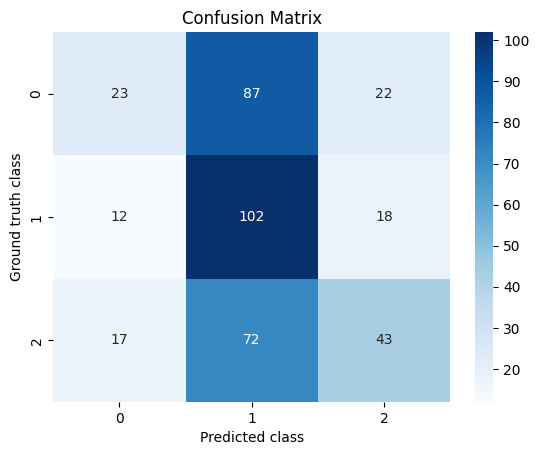

In [83]:
yc_pred = net1_without_balancing.predict(test_data)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in test_data], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.show()

In [84]:
def metriche(mx):
    acc = round((mx[0][0]+mx[1][1]+mx[2][2])/(132*3),4)
    rec_mel = round(mx[0][0]/(mx[0][0]+mx[0][1]+mx[0][2]),4)
    rec_nev = round(mx[1][1]/(mx[1][0]+mx[1][1]+mx[1][2]),4)
    rec_sk = round(mx[2][2]/(mx[2][0]+mx[2][1]+mx[2][2]),4)
    return acc, rec_mel, rec_nev, rec_sk

<IPython.core.display.Javascript object>

In [85]:
evaluation = metriche(cm)
print("Accuracy: ", evaluation[0])
print("Recall Melanoma: ", evaluation[1])
print("Recall Nevus: ", evaluation[2])
print("Recall SK: ", evaluation[3])

<IPython.core.display.Javascript object>

Accuracy:  0.4242
Recall Melanoma:  0.1742
Recall Nevus:  0.7727
Recall SK:  0.3258


In [20]:
net1_without_balancing.save('/Users/Vitto_1/Desktop/MODELLI/net1_without_balancing.h5')

<IPython.core.display.Javascript object>

/Users/Vitto_1/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



### Model 2

In [21]:
# Architecture definition

# Defining the input of the model with dimensions 224x224 and 3 color channels (RGB)
inputs = keras.Input((224, 224, 3))

x = inputs

# Adding a convolutional layer with 32 filters, kernel size of 3x3, "same" padding, and L2 regularization with a factor of 0.001
x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# Adding batch normalization to normalize the activations of the previous layer
x = keras.layers.BatchNormalization()(x)
# Applying the "relu" activation function to the output of the previous layer
x = keras.layers.Activation("relu")(x)
# Applying a MaxPooling layer with a pool size of 3x3, stride of 3, and "same" padding
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# Adding another convolutional layer with 64 filters, kernel size of 3x3, "same" padding, and L2 regularization with a factor of 0.001
x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# Adding batch normalization to normalize the activations of the previous layer
x = keras.layers.BatchNormalization()(x)
# Applying the "relu" activation function to the output of the previous layer
x = keras.layers.Activation("relu")(x)
# Applying a MaxPooling layer with a pool size of 3x3, stride of 3, and "same" padding
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# Adding another convolutional layer with 128 filters, kernel size of 3x3, "same" padding, and L2 regularization with a factor of 0.001
x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# Adding batch normalization to normalize the activations of the previous layer
x = keras.layers.BatchNormalization()(x)
# Applying the "relu" activation function to the output of the previous layer
x = keras.layers.Activation("relu")(x)

# Applying a GlobalMaxPooling layer to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)

# Adding a fully connected layer with 64 units, "relu" activation, and L2 regularization with a factor of 0.001
x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

# Adding a final fully connected layer with num_classes units, softmax activation, and L2 regularization with a factor of 0.001
outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

# Creating the model with the defined inputs and outputs
net2_without_balancing = keras.Model(inputs, outputs)


<IPython.core.display.Javascript object>

In [22]:
# Compile the model for training
net2_without_balancing.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adagrad(learning_rate=0.001),
            metrics=[tf.keras.metrics.CategoricalAccuracy()])

<IPython.core.display.Javascript object>

In [23]:
# Model training
history2_without_balancing = net2_without_balancing.fit(train_data,
                                                        epochs=100,
                                                        validation_data=test_data,
                                                        callbacks=[callback])

<IPython.core.display.Javascript object>

Epoch 1/100
63/63 [==============================] - 112s 2s/step - loss: 1.3202 - categorical_accuracy: 0.6490 - val_loss: 2.5671 - val_categorical_accuracy: 0.3333
Epoch 2/100
63/63 [==============================] - 111s 2s/step - loss: 0.9677 - categorical_accuracy: 0.6960 - val_loss: 1.6470 - val_categorical_accuracy: 0.3586
Epoch 3/100
63/63 [==============================] - 111s 2s/step - loss: 0.9288 - categorical_accuracy: 0.7150 - val_loss: 1.4321 - val_categorical_accuracy: 0.4015
Epoch 4/100
63/63 [==============================] - 111s 2s/step - loss: 0.8976 - categorical_accuracy: 0.7185 - val_loss: 1.3066 - val_categorical_accuracy: 0.4747
Epoch 5/100
63/63 [==============================] - 111s 2s/step - loss: 0.8752 - categorical_accuracy: 0.7325 - val_loss: 1.3421 - val_categorical_accuracy: 0.4470
Epoch 6/100
63/63 [==============================] - 111s 2s/step - loss: 0.8580 - categorical_accuracy: 0.7355 - val_loss: 1.3294 - val_categorical_accuracy: 0.4545
Epoc

In [24]:
# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_without_balancing.history['loss']) + 1)),
    y=history2_without_balancing.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_without_balancing.history['val_loss']) + 1)),
    y=history2_without_balancing.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss', range=[0,2]),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()


# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_without_balancing.history['categorical_accuracy']) + 1)),
    y=history2_without_balancing.history['categorical_accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_without_balancing.history['val_categorical_accuracy']) + 1)),
    y=history2_without_balancing.history['val_categorical_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy', range=[0,1]),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

<IPython.core.display.Javascript object>

In [25]:
net2_without_balancing.evaluate(test_data)

<IPython.core.display.Javascript object>

13/13 [==============================] - 20s 2s/step - loss: 1.3507 - categorical_accuracy: 0.4571


[1.3506858348846436, 0.4570707082748413]

<IPython.core.display.Javascript object>

13/13 [==============================] - 47s 4s/step


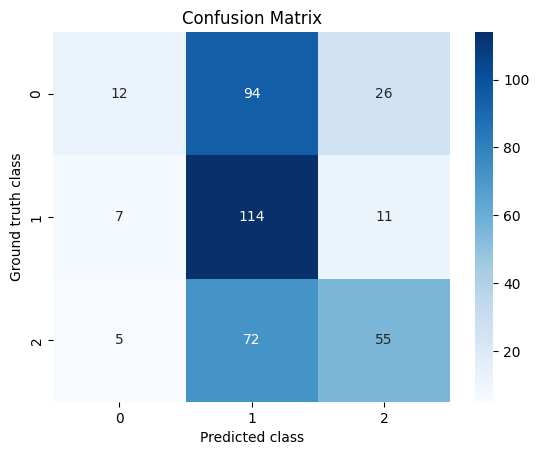

In [87]:
yc_pred = net2_without_balancing.predict(test_data)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in test_data], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.show()

In [88]:
evaluation = metriche(cm)
print("Accuracy: ", evaluation[0])
print("Recall Melanoma: ", evaluation[1])
print("Recall Nevus: ", evaluation[2])
print("Recall SK: ", evaluation[3])

<IPython.core.display.Javascript object>

Accuracy:  0.4571
Recall Melanoma:  0.0909
Recall Nevus:  0.8636
Recall SK:  0.4167


In [27]:
net2_without_balancing.save('/Users/Vitto_1/Desktop/MODELLI/net2_without_balancing.h5')

<IPython.core.display.Javascript object>

/Users/Vitto_1/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



### Model 3

In [28]:
# Base model

# Using the pre-trained ResNet50 model as the base model with input shape (224, 224, 3)
base_net = keras.applications.ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
# Freezing the weights of the base model to prevent them from being updated during training
base_net.trainable = False

# Explicit input layer
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# Preprocessing the input using the preprocessing function of ResNet50
x = keras.applications.resnet50.preprocess_input(x)
# Passing the preprocessed input through the base model
x = base_net(x)
# Adding a convolutional layer with 64 filters and kernel size of 3x3 to further process the features
x = keras.layers.Conv2D(64, 3, padding="same")(x)
# Applying GlobalMaxPooling to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)
# Adding a dense layer with softmax activation for the final classification
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

# Creating the specialized model by defining the inputs and outputs
net3_without_balancing = keras.Model(inputs=inputs, outputs=outputs)

<IPython.core.display.Javascript object>

In [29]:
# Compile the model for training
net3_without_balancing.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adagrad(learning_rate=0.001),
            metrics=[tf.keras.metrics.CategoricalAccuracy()])

<IPython.core.display.Javascript object>

In [30]:
# Model training
history3_without_balancing = net3_without_balancing.fit(train_data,
                                                        epochs=100,
                                                        validation_data=test_data,
                                                        callbacks=[callback])

<IPython.core.display.Javascript object>

Epoch 1/100
63/63 [==============================] - 180s 3s/step - loss: 2.2263 - categorical_accuracy: 0.6255 - val_loss: 1.2359 - val_categorical_accuracy: 0.5631
Epoch 2/100
63/63 [==============================] - 176s 3s/step - loss: 0.4048 - categorical_accuracy: 0.8400 - val_loss: 1.0544 - val_categorical_accuracy: 0.5808
Epoch 3/100
63/63 [==============================] - 177s 3s/step - loss: 0.1796 - categorical_accuracy: 0.9495 - val_loss: 1.1139 - val_categorical_accuracy: 0.5732
Epoch 4/100
63/63 [==============================] - 176s 3s/step - loss: 0.0992 - categorical_accuracy: 0.9885 - val_loss: 1.1818 - val_categorical_accuracy: 0.5707
Epoch 5/100
63/63 [==============================] - 177s 3s/step - loss: 0.0690 - categorical_accuracy: 0.9960 - val_loss: 1.2014 - val_categorical_accuracy: 0.5783
Epoch 6/100
63/63 [==============================] - 177s 3s/step - loss: 0.0532 - categorical_accuracy: 0.9985 - val_loss: 1.3758 - val_categorical_accuracy: 0.5581
Epoc

In [31]:
# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_without_balancing.history['loss']) + 1)),
    y=history3_without_balancing.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_without_balancing.history['val_loss']) + 1)),
    y=history3_without_balancing.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss', range=[0,2]),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()


# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_without_balancing.history['categorical_accuracy']) + 1)),
    y=history3_without_balancing.history['categorical_accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_without_balancing.history['val_categorical_accuracy']) + 1)),
    y=history3_without_balancing.history['val_categorical_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy', range=[0,1]),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

<IPython.core.display.Javascript object>

In [32]:
net3_without_balancing.evaluate(test_data)

<IPython.core.display.Javascript object>

13/13 [==============================] - 36s 3s/step - loss: 1.3056 - categorical_accuracy: 0.5707


[1.305647611618042, 0.5707070827484131]

<IPython.core.display.Javascript object>

13/13 [==============================] - 83s 6s/step


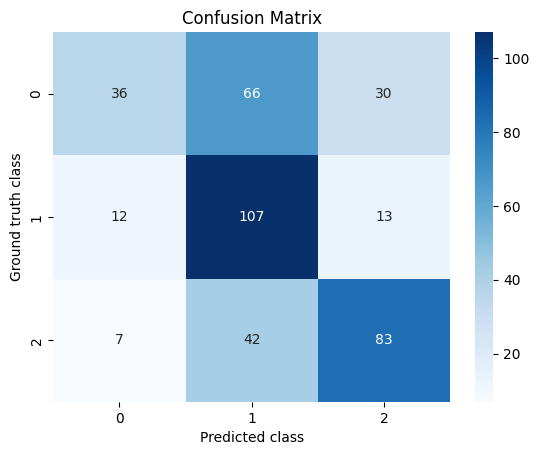

In [90]:
yc_pred = net3_without_balancing.predict(test_data)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in test_data], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.show()

In [91]:
evaluation = metriche(cm)
print("Accuracy: ", evaluation[0])
print("Recall Melanoma: ", evaluation[1])
print("Recall Nevus: ", evaluation[2])
print("Recall SK: ", evaluation[3])

<IPython.core.display.Javascript object>

Accuracy:  0.5707
Recall Melanoma:  0.2727
Recall Nevus:  0.8106
Recall SK:  0.6288


In [34]:
net3_without_balancing.save('/Users/Vitto_1/Desktop/MODELLI/net3_without_balancing.h5')

<IPython.core.display.Javascript object>

/Users/Vitto_1/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



### Model 4

In [35]:
# Base model

# Using the pre-trained MobileNetV2 model as the base model with input shape (224, 224, 3)
base_net = keras.applications.MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
# Freezing the weights of the base model to prevent them from being updated during training
base_net.trainable = False

# Explicit input layer
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# Preprocessing the input using the preprocessing function of MobileNetV2
x = keras.applications.mobilenet_v2.preprocess_input(x)
# Passing the preprocessed input through the base model
x = base_net(x)
# Adding a convolutional layer with 64 filters and kernel size of 3x3 to further process the features
x = keras.layers.Conv2D(64, 3, padding="same")(x)
# Applying GlobalMaxPooling to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)
# Adding a dense layer with softmax activation for the final classification
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

# Creating the specialized model by defining the inputs and outputs
net4_without_balancing = keras.Model(inputs=inputs, outputs=outputs)

<IPython.core.display.Javascript object>

In [36]:
# Compile the model for training
net4_without_balancing.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adagrad(learning_rate=0.001),
            metrics=[tf.keras.metrics.CategoricalAccuracy()])

<IPython.core.display.Javascript object>

In [37]:
# Model training
history4_without_balancing = net4_without_balancing.fit(train_data,
                                                        epochs=100,
                                                        validation_data=test_data,
                                                        callbacks=[callback])

<IPython.core.display.Javascript object>

Epoch 1/100
63/63 [==============================] - 100s 1s/step - loss: 1.2552 - categorical_accuracy: 0.6515 - val_loss: 2.6030 - val_categorical_accuracy: 0.3611
Epoch 2/100
63/63 [==============================] - 97s 1s/step - loss: 0.4662 - categorical_accuracy: 0.8170 - val_loss: 1.4276 - val_categorical_accuracy: 0.4899
Epoch 3/100
63/63 [==============================] - 97s 1s/step - loss: 0.2683 - categorical_accuracy: 0.9075 - val_loss: 1.3765 - val_categorical_accuracy: 0.5101
Epoch 4/100
63/63 [==============================] - 97s 1s/step - loss: 0.1823 - categorical_accuracy: 0.9615 - val_loss: 1.1479 - val_categorical_accuracy: 0.5657
Epoch 5/100
63/63 [==============================] - 97s 1s/step - loss: 0.1328 - categorical_accuracy: 0.9855 - val_loss: 1.2444 - val_categorical_accuracy: 0.5429
Epoch 6/100
63/63 [==============================] - 97s 1s/step - loss: 0.1047 - categorical_accuracy: 0.9940 - val_loss: 1.1414 - val_categorical_accuracy: 0.5783
Epoch 7/1

In [38]:
# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_without_balancing.history['loss']) + 1)),
    y=history4_without_balancing.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_without_balancing.history['val_loss']) + 1)),
    y=history4_without_balancing.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss', range=[0,2]),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()


# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_without_balancing.history['categorical_accuracy']) + 1)),
    y=history4_without_balancing.history['categorical_accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_without_balancing.history['val_categorical_accuracy']) + 1)),
    y=history4_without_balancing.history['val_categorical_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy', range=[0,1]),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

<IPython.core.display.Javascript object>

In [39]:
net4_without_balancing.evaluate(test_data)

<IPython.core.display.Javascript object>

13/13 [==============================] - 22s 2s/step - loss: 1.2967 - categorical_accuracy: 0.5556


[1.296679139137268, 0.5555555820465088]

<IPython.core.display.Javascript object>

13/13 [==============================] - 59s 4s/step


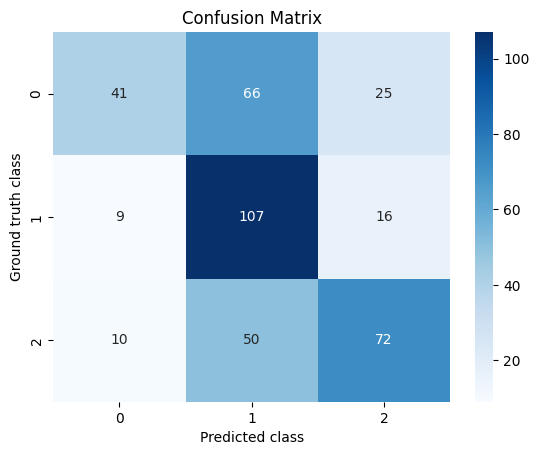

In [93]:
yc_pred = net4_without_balancing.predict(test_data)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in test_data], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.show()

In [94]:
evaluation = metriche(cm)
print("Accuracy: ", evaluation[0])
print("Recall Melanoma: ", evaluation[1])
print("Recall Nevus: ", evaluation[2])
print("Recall SK: ", evaluation[3])

<IPython.core.display.Javascript object>

Accuracy:  0.5556
Recall Melanoma:  0.3106
Recall Nevus:  0.8106
Recall SK:  0.5455


In [41]:
net4_without_balancing.save('/Users/Vitto_1/Desktop/MODELLI/net4_without_balancing.h5')

<IPython.core.display.Javascript object>

/Users/Vitto_1/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



## Defining a model With weight correction

### Model 1

In [42]:
# Architecture definition

# Defining the input of the model with dimensions 224x224 and 3 color channels (RGB)
inputs = keras.Input((224, 224, 3))

x = inputs

# Adding a convolutional layer with 32 filters, kernel size of 3x3, and "same" padding
x = keras.layers.Conv2D(32, 3, padding="same")(x)
# Applying the "relu" activation function to the output of the convolutional layer
x = keras.layers.Activation("relu")(x)
# Applying a MaxPooling layer with a pool size of 3x3, stride of 3, and "same" padding
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# Adding another convolutional layer with 64 filters and a kernel size of 3x3
x = keras.layers.Conv2D(64, 3, padding="same")(x)
# Applying the "relu" activation function to the output of the convolutional layer
x = keras.layers.Activation("relu")(x)

# Applying a GlobalMaxPooling layer to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)

# Adding a fully connected layer with softmax activation for the final classification
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

# Creating the model with the defined inputs and outputs
net1_weight = keras.Model(inputs, outputs)

<IPython.core.display.Javascript object>

In [43]:
# Compile the model for training

net1_weight.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adagrad(learning_rate=0.001),
            metrics=[tf.keras.metrics.CategoricalAccuracy()])

<IPython.core.display.Javascript object>

In [44]:
history1_weight = net1_weight.fit(train_data,
                                  class_weight= W,
                                  epochs=100,
                                  validation_data=test_data,
                                  callbacks=[callback])

<IPython.core.display.Javascript object>

Epoch 1/100
63/63 [==============================] - 95s 1s/step - loss: 5.4871 - categorical_accuracy: 0.4345 - val_loss: 4.3958 - val_categorical_accuracy: 0.3813
Epoch 2/100
63/63 [==============================] - 95s 1s/step - loss: 2.8138 - categorical_accuracy: 0.4660 - val_loss: 4.9864 - val_categorical_accuracy: 0.3914
Epoch 3/100
63/63 [==============================] - 95s 1s/step - loss: 2.3611 - categorical_accuracy: 0.4800 - val_loss: 3.6617 - val_categorical_accuracy: 0.4015
Epoch 4/100
63/63 [==============================] - 95s 1s/step - loss: 2.0425 - categorical_accuracy: 0.5010 - val_loss: 2.9901 - val_categorical_accuracy: 0.4343
Epoch 5/100
63/63 [==============================] - 95s 1s/step - loss: 1.8665 - categorical_accuracy: 0.5150 - val_loss: 2.6579 - val_categorical_accuracy: 0.4394
Epoch 6/100
63/63 [==============================] - 95s 1s/step - loss: 1.8297 - categorical_accuracy: 0.5120 - val_loss: 2.8824 - val_categorical_accuracy: 0.4066
Epoch 7/10

In [45]:
import plotly.graph_objects as go

# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_weight.history['loss']) + 1)),
    y=history1_weight.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_weight.history['val_loss']) + 1)),
    y=history1_weight.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss', range=[0,2]),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()


# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_weight.history['categorical_accuracy']) + 1)),
    y=history1_weight.history['categorical_accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_weight.history['val_categorical_accuracy']) + 1)),
    y=history1_weight.history['val_categorical_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy', range=[0,1]),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

<IPython.core.display.Javascript object>

In [46]:
net1_weight.evaluate(test_data)

<IPython.core.display.Javascript object>

13/13 [==============================] - 20s 2s/step - loss: 2.5663 - categorical_accuracy: 0.3990


[2.5663235187530518, 0.39898988604545593]

<IPython.core.display.Javascript object>

13/13 [==============================] - 51s 4s/step


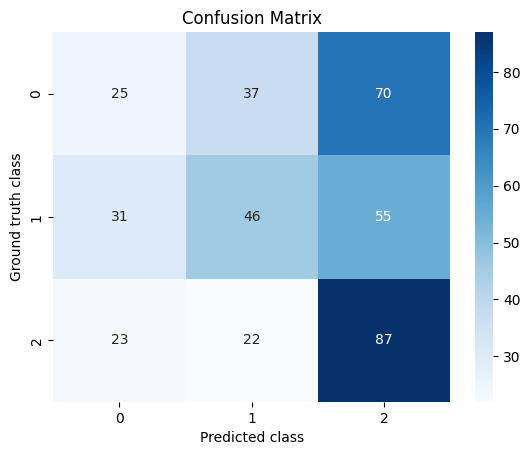

In [97]:
yc_pred = net1_weight.predict(test_data)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in test_data], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
#plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.show()

In [98]:
evaluation = metriche(cm)
print("Accuracy: ", evaluation[0])
print("Recall Melanoma: ", evaluation[1])
print("Recall Nevus: ", evaluation[2])
print("Recall SK: ", evaluation[3])

<IPython.core.display.Javascript object>

Accuracy:  0.399
Recall Melanoma:  0.1894
Recall Nevus:  0.3485
Recall SK:  0.6591


In [48]:
net1_weight.save('/Users/Vitto_1/Desktop/MODELLI/net1_weight.h5')

<IPython.core.display.Javascript object>

/Users/Vitto_1/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



### Model 2

In [49]:
# Architecture definition

# Defining the input of the model with dimensions 224x224 and 3 color channels (RGB)
inputs = keras.Input((224, 224, 3))

x = inputs

# Adding a convolutional layer with 32 filters, kernel size of 3x3, "same" padding, and L2 regularization with a factor of 0.001
x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# Adding batch normalization to normalize the activations of the previous layer
x = keras.layers.BatchNormalization()(x)
# Applying the "relu" activation function to the output of the previous layer
x = keras.layers.Activation("relu")(x)
# Applying a MaxPooling layer with a pool size of 3x3, stride of 3, and "same" padding
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# Adding another convolutional layer with 64 filters, kernel size of 3x3, "same" padding, and L2 regularization with a factor of 0.001
x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# Adding batch normalization to normalize the activations of the previous layer
x = keras.layers.BatchNormalization()(x)
# Applying the "relu" activation function to the output of the previous layer
x = keras.layers.Activation("relu")(x)
# Applying a MaxPooling layer with a pool size of 3x3, stride of 3, and "same" padding
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# Adding another convolutional layer with 128 filters, kernel size of 3x3, "same" padding, and L2 regularization with a factor of 0.001
x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# Adding batch normalization to normalize the activations of the previous layer
x = keras.layers.BatchNormalization()(x)
# Applying the "relu" activation function to the output of the previous layer
x = keras.layers.Activation("relu")(x)

# Applying a GlobalMaxPooling layer to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)

# Adding a fully connected layer with 64 units, "relu" activation, and L2 regularization with a factor of 0.001
x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

# Adding a final fully connected layer with num_classes units, softmax activation, and L2 regularization with a factor of 0.001
outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

# Creating the model with the defined inputs and outputs
net2_weight = keras.Model(inputs, outputs)


<IPython.core.display.Javascript object>

In [50]:
net2_weight.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adagrad(learning_rate=0.001),
            metrics=[tf.keras.metrics.CategoricalAccuracy()])

<IPython.core.display.Javascript object>

In [51]:
history2_weight = net2_weight.fit(train_data,
                                  class_weight = W,
                                  epochs=100,
                                  validation_data=test_data,
                                  callbacks=[callback])

<IPython.core.display.Javascript object>

Epoch 1/100
63/63 [==============================] - 112s 2s/step - loss: 1.3948 - categorical_accuracy: 0.4545 - val_loss: 1.7264 - val_categorical_accuracy: 0.3409
Epoch 2/100
63/63 [==============================] - 112s 2s/step - loss: 1.0720 - categorical_accuracy: 0.5385 - val_loss: 1.7942 - val_categorical_accuracy: 0.3333
Epoch 3/100
63/63 [==============================] - 111s 2s/step - loss: 1.0160 - categorical_accuracy: 0.5745 - val_loss: 1.3350 - val_categorical_accuracy: 0.4015
Epoch 4/100
63/63 [==============================] - 112s 2s/step - loss: 0.9793 - categorical_accuracy: 0.6005 - val_loss: 1.2879 - val_categorical_accuracy: 0.4091
Epoch 5/100
63/63 [==============================] - 112s 2s/step - loss: 0.9406 - categorical_accuracy: 0.6175 - val_loss: 1.3952 - val_categorical_accuracy: 0.4091
Epoch 6/100
63/63 [==============================] - 112s 2s/step - loss: 0.9276 - categorical_accuracy: 0.6260 - val_loss: 1.2482 - val_categorical_accuracy: 0.4697
Epoc

In [52]:
# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_weight.history['loss']) + 1)),
    y=history2_weight.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_weight.history['val_loss']) + 1)),
    y=history2_weight.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss', range=[0,2]),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()


# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_weight.history['categorical_accuracy']) + 1)),
    y=history2_weight.history['categorical_accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_weight.history['val_categorical_accuracy']) + 1)),
    y=history2_weight.history['val_categorical_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy', range=[0,1]),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

<IPython.core.display.Javascript object>

In [53]:
net2_weight.evaluate(test_data)

<IPython.core.display.Javascript object>

13/13 [==============================] - 20s 2s/step - loss: 1.2857 - categorical_accuracy: 0.5076


[1.2856675386428833, 0.5075757503509521]

<IPython.core.display.Javascript object>

13/13 [==============================] - 55s 4s/step


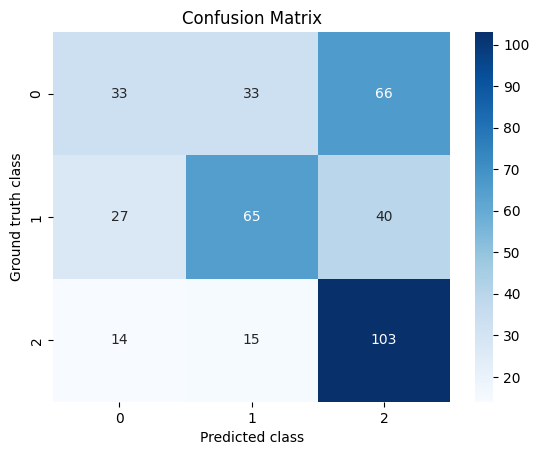

In [100]:
yc_pred = net2_weight.predict(test_data)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in test_data], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.show()

In [101]:
evaluation = metriche(cm)
print("Accuracy: ", evaluation[0])
print("Recall Melanoma: ", evaluation[1])
print("Recall Nevus: ", evaluation[2])
print("Recall SK: ", evaluation[3])

<IPython.core.display.Javascript object>

Accuracy:  0.5076
Recall Melanoma:  0.25
Recall Nevus:  0.4924
Recall SK:  0.7803


In [55]:
net2_without_balancing.save('/Users/Vitto_1/Desktop/MODELLI/net2_weight.h5')

<IPython.core.display.Javascript object>

/Users/Vitto_1/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



### Model 3

In [56]:
# Base model

# Using the pre-trained ResNet50 model as the base model with input shape (224, 224, 3)
base_net = keras.applications.ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
# Freezing the weights of the base model to prevent them from being updated during training
base_net.trainable = False

# Explicit input layer
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# Preprocessing the input using the preprocessing function of ResNet50
x = keras.applications.resnet50.preprocess_input(x)
# Passing the preprocessed input through the base model
x = base_net(x)
# Adding a convolutional layer with 64 filters and kernel size of 3x3 to further process the features
x = keras.layers.Conv2D(64, 3, padding="same")(x)
# Applying GlobalMaxPooling to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)
# Adding a dense layer with softmax activation for the final classification
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

# Creating the specialized model by defining the inputs and outputs
net3_weight = keras.Model(inputs=inputs, outputs=outputs)

<IPython.core.display.Javascript object>

In [57]:
net3_weight.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
            optimizer=keras.optimizers.Adagrad(learning_rate=0.001),
            metrics=["categorical_accuracy"])

<IPython.core.display.Javascript object>

In [58]:
history3_weight = net3_weight.fit(train_data,
                                  class_weight= W,
                                  epochs=100,
                                  validation_data=test_data,
                                  callbacks=[callback])

<IPython.core.display.Javascript object>

Epoch 1/100
63/63 [==============================] - 181s 3s/step - loss: 2.1218 - categorical_accuracy: 0.5155 - val_loss: 1.1516 - val_categorical_accuracy: 0.5682
Epoch 2/100
63/63 [==============================] - 178s 3s/step - loss: 0.4565 - categorical_accuracy: 0.7795 - val_loss: 1.1706 - val_categorical_accuracy: 0.5657
Epoch 3/100
63/63 [==============================] - 178s 3s/step - loss: 0.2299 - categorical_accuracy: 0.9065 - val_loss: 1.1061 - val_categorical_accuracy: 0.5707
Epoch 4/100
63/63 [==============================] - 178s 3s/step - loss: 0.1441 - categorical_accuracy: 0.9610 - val_loss: 1.2329 - val_categorical_accuracy: 0.5404
Epoch 5/100
63/63 [==============================] - 178s 3s/step - loss: 0.1065 - categorical_accuracy: 0.9780 - val_loss: 1.1845 - val_categorical_accuracy: 0.5556
Epoch 6/100
63/63 [==============================] - 178s 3s/step - loss: 0.0854 - categorical_accuracy: 0.9895 - val_loss: 1.1626 - val_categorical_accuracy: 0.5682
Epoc

In [59]:
# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_weight.history['loss']) + 1)),
    y=history3_weight.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_weight.history['val_loss']) + 1)),
    y=history3_weight.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss', range=[0,2]),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()


# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_weight.history['categorical_accuracy']) + 1)),
    y=history3_weight.history['categorical_accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_weight.history['val_categorical_accuracy']) + 1)),
    y=history3_weight.history['val_categorical_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy', range=[0,1]),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

<IPython.core.display.Javascript object>

In [60]:
net3_weight.evaluate(test_data)

<IPython.core.display.Javascript object>

13/13 [==============================] - 36s 3s/step - loss: 1.2095 - categorical_accuracy: 0.5606


[1.209456443786621, 0.560606062412262]

<IPython.core.display.Javascript object>

13/13 [==============================] - 75s 5s/step


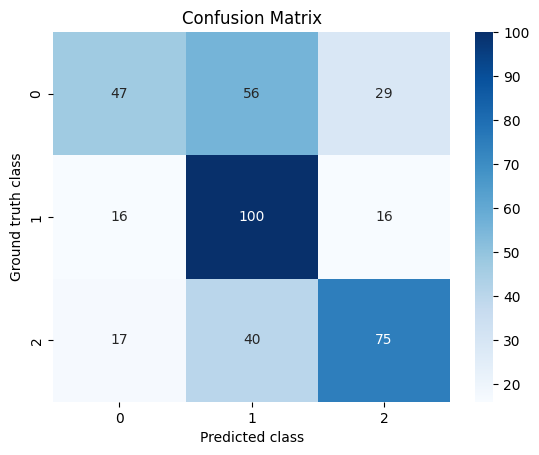

In [108]:
yc_pred = net3_weight.predict(test_data)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in test_data], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.show()

In [110]:
evaluation = metriche(cm)
print("Accuracy: ", evaluation[0])
print("Recall Melanoma: ", evaluation[1])
print("Recall Nevus: ", evaluation[2])
print("Recall SK: ", evaluation[3])

<IPython.core.display.Javascript object>

Accuracy:  0.5606
Recall Melanoma:  0.3561
Recall Nevus:  0.7576
Recall SK:  0.5682


In [62]:
net3_weight.save('/Users/Vitto_1/Desktop/MODELLI/net3_weight.h5')

<IPython.core.display.Javascript object>

/Users/Vitto_1/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



### Model 4

In [63]:
# Base model

# Using the pre-trained MobileNetV2 model as the base model with input shape (224, 224, 3)
base_net = keras.applications.MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
# Freezing the weights of the base model to prevent them from being updated during training
base_net.trainable = False

# Explicit input layer
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# Preprocessing the input using the preprocessing function of MobileNetV2
x = keras.applications.mobilenet_v2.preprocess_input(x)
# Passing the preprocessed input through the base model
x = base_net(x)
# Adding a convolutional layer with 64 filters and kernel size of 3x3 to further process the features
x = keras.layers.Conv2D(64, 3, padding="same")(x)
# Applying GlobalMaxPooling to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)
# Adding a dense layer with softmax activation for the final classification
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

# Creating the specialized model by defining the inputs and outputs
net4_weight = keras.Model(inputs=inputs, outputs=outputs)

<IPython.core.display.Javascript object>

In [64]:
net4_weight.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adagrad(learning_rate=0.001),
            metrics=[tf.keras.metrics.CategoricalAccuracy()])

<IPython.core.display.Javascript object>

In [65]:
# Model training
history4_weight = net4_weight.fit(train_data,
                                  class_weight= W,
                                  epochs=100,
                                  validation_data=test_data,
                                  callbacks=[callback])

<IPython.core.display.Javascript object>

Epoch 1/100
63/63 [==============================] - 100s 1s/step - loss: 1.4779 - categorical_accuracy: 0.5385 - val_loss: 1.4115 - val_categorical_accuracy: 0.5202
Epoch 2/100
63/63 [==============================] - 98s 1s/step - loss: 0.4703 - categorical_accuracy: 0.7795 - val_loss: 1.0232 - val_categorical_accuracy: 0.5758
Epoch 3/100
63/63 [==============================] - 98s 1s/step - loss: 0.2849 - categorical_accuracy: 0.8835 - val_loss: 0.9987 - val_categorical_accuracy: 0.5657
Epoch 4/100
63/63 [==============================] - 98s 1s/step - loss: 0.1978 - categorical_accuracy: 0.9510 - val_loss: 1.1043 - val_categorical_accuracy: 0.5707
Epoch 5/100
63/63 [==============================] - 98s 1s/step - loss: 0.1485 - categorical_accuracy: 0.9730 - val_loss: 1.0540 - val_categorical_accuracy: 0.5732
Epoch 6/100
63/63 [==============================] - 98s 1s/step - loss: 0.1196 - categorical_accuracy: 0.9855 - val_loss: 1.0421 - val_categorical_accuracy: 0.5884
Epoch 7/1

In [66]:
# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_weight.history['loss']) + 1)),
    y=history4_weight.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_weight.history['val_loss']) + 1)),
    y=history4_weight.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss', range=[0,2]),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()


# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_weight.history['categorical_accuracy']) + 1)),
    y=history4_weight.history['categorical_accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_weight.history['val_categorical_accuracy']) + 1)),
    y=history4_weight.history['val_categorical_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy', range=[0,1]),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

<IPython.core.display.Javascript object>

In [67]:
net4_weight.evaluate(test_data)

<IPython.core.display.Javascript object>

13/13 [==============================] - 22s 2s/step - loss: 1.0787 - categorical_accuracy: 0.6035


[1.078744888305664, 0.6035353541374207]

<IPython.core.display.Javascript object>

13/13 [==============================] - 62s 4s/step


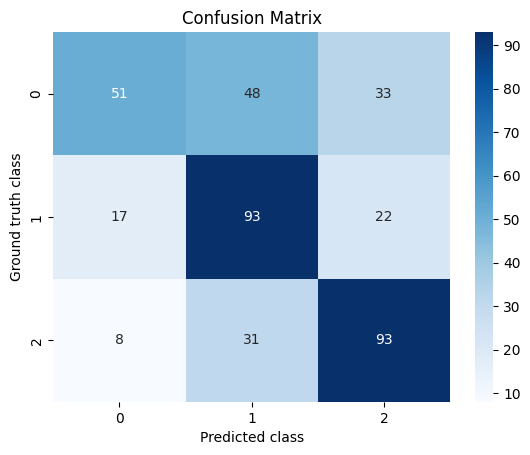

In [104]:
yc_pred = net4_weight.predict(test_data)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in test_data], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.show()

In [105]:
evaluation = metriche(cm)
print("Accuracy: ", evaluation[0])
print("Recall Melanoma: ", evaluation[1])
print("Recall Nevus: ", evaluation[2])
print("Recall SK: ", evaluation[3])

<IPython.core.display.Javascript object>

Accuracy:  0.5985
Recall Melanoma:  0.3864
Recall Nevus:  0.7045
Recall SK:  0.7045


In [69]:
net4_weight.save('/Users/Vitto_1/Desktop/MODELLI/net4_weight.h5')

<IPython.core.display.Javascript object>

/Users/Vitto_1/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



## Defining a model With Data Augmentation

### Model

In [70]:
# Using the pre-trained MobileNetV2 model as the base model with input shape (224, 224, 3)
base_net = keras.applications.MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
# Freezing the weights of the base model to prevent them from being updated during training
base_net.trainable = False

# Explicit input layer
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# Data Augmentation
# Randomly flipping the input horizontally
x = keras.layers.RandomFlip(mode='horizontal')(x)
# Randomly rotating the input by 10 degrees
x = keras.layers.RandomRotation(10)(x)
# Randomly zooming the input by a factor of 0.2
x = keras.layers.RandomZoom(0.2)(x)

# Preprocessing the input using the preprocessing function of MobileNetV2
x = keras.applications.mobilenet_v2.preprocess_input(x)
# Passing the preprocessed input through the base model
x = base_net(x)
# Adding a convolutional layer with 64 filters and kernel size of 3x3 to further process the features
x = keras.layers.Conv2D(64, 3, padding="same")(x)
# Applying GlobalMaxPooling to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)
# Adding a dense layer with softmax activation for the final classification
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

# Creating the specialized model by defining the inputs and outputs
net4_data_augmentation = keras.Model(inputs=inputs, outputs=outputs)


<IPython.core.display.Javascript object>

In [71]:
# Compile the model for training
net4_data_augmentation.compile(loss=keras.losses.categorical_crossentropy,
                               optimizer=keras.optimizers.Adagrad(learning_rate=0.001),
                                 metrics=[tf.keras.metrics.CategoricalAccuracy()])

<IPython.core.display.Javascript object>

In [72]:
# Model training
history4_data_augmentation = net4_data_augmentation.fit(train_data,
                                                        class_weight=W,
                                                        epochs=100,
                                                        validation_data=test_data,
                                                        callbacks=[callback])

<IPython.core.display.Javascript object>

Epoch 1/100
63/63 [==============================] - 104s 2s/step - loss: 1.5197 - categorical_accuracy: 0.4955 - val_loss: 1.1246 - val_categorical_accuracy: 0.5227
Epoch 2/100
63/63 [==============================] - 101s 1s/step - loss: 0.8797 - categorical_accuracy: 0.5955 - val_loss: 1.2686 - val_categorical_accuracy: 0.5202
Epoch 3/100
63/63 [==============================] - 101s 1s/step - loss: 0.7742 - categorical_accuracy: 0.6220 - val_loss: 1.1885 - val_categorical_accuracy: 0.5278
Epoch 4/100
63/63 [==============================] - 101s 1s/step - loss: 0.7315 - categorical_accuracy: 0.6220 - val_loss: 1.1288 - val_categorical_accuracy: 0.5455
Epoch 5/100
63/63 [==============================] - 101s 1s/step - loss: 0.7496 - categorical_accuracy: 0.6280 - val_loss: 1.1197 - val_categorical_accuracy: 0.5227
Epoch 6/100
63/63 [==============================] - 101s 1s/step - loss: 0.6813 - categorical_accuracy: 0.6745 - val_loss: 1.1245 - val_categorical_accuracy: 0.5530
Epoc

In [73]:
import plotly.graph_objects as go

# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_data_augmentation.history['loss']) + 1)),
    y=history4_data_augmentation.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='black')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_data_augmentation.history['val_loss']) + 1)),
    y=history4_data_augmentation.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='gray', dash='dashdot')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_data_augmentation.history['categorical_accuracy']) + 1)),
    y=history4_data_augmentation.history['categorical_accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='black')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_data_augmentation.history['val_categorical_accuracy']) + 1)),
    y=history4_data_augmentation.history['val_categorical_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='gray', dash='dashdot')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()



<IPython.core.display.Javascript object>

In [74]:
net4_data_augmentation.evaluate(test_data)

<IPython.core.display.Javascript object>

13/13 [==============================] - 22s 2s/step - loss: 1.0489 - categorical_accuracy: 0.5859


[1.0488845109939575, 0.5858585834503174]

<IPython.core.display.Javascript object>

13/13 [==============================] - 59s 4s/step


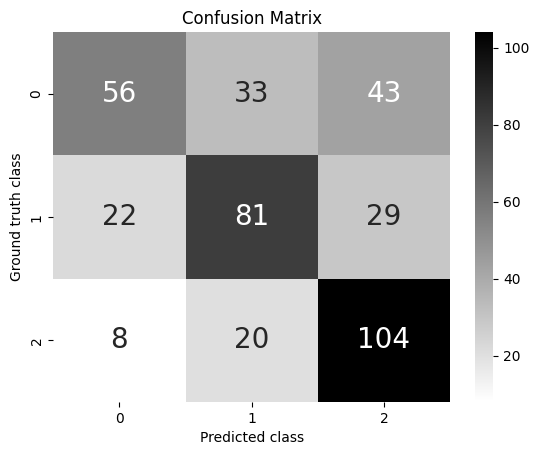

In [112]:
yc_pred = net4_data_augmentation.predict(test_data)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in test_data], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='gray_r', annot_kws={"size": 20})
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.show()

In [113]:
evaluation = metriche(cm)
print("Accuracy: ", evaluation[0])
print("Recall Melanoma: ", evaluation[1])
print("Recall Nevus: ", evaluation[2])
print("Recall SK: ", evaluation[3])

<IPython.core.display.Javascript object>

Accuracy:  0.6086
Recall Melanoma:  0.4242
Recall Nevus:  0.6136
Recall SK:  0.7879


In [ ]:
net4_data_augmentation.save('/Users/Vitto_1/Desktop/MODELLI/net4_data_augmentation.h5')

# EXPLAINABILITY

## LIME

In [125]:
def transform_img_fn(path_list):
    # Initialize an empty list to store the transformed images
    out = []

    # Iterate over each image path in the path_list
    for img_path in path_list:
        # Load the image and resize it to the target size of (224, 224)
        img = im.load_img(img_path, target_size=(224, 224))

        # Convert the image to an array
        x = im.img_to_array(img)

        # Expand the dimensions of the image array to match the expected input shape
        x = np.expand_dims(x, axis=0)

        # Preprocess the image according to the requirements of the inc_net model
        x = inc_net.preprocess_input(x)

        # Append the preprocessed image to the output list
        out.append(x)

    # Stack the preprocessed images vertically to create a single array
    return np.vstack(out)

<IPython.core.display.Javascript object>

In [126]:
path_prov = "/Users/Vitto_1/Desktop/testing"

<IPython.core.display.Javascript object>

In [127]:
lime_test = keras.preprocessing.image_dataset_from_directory(path_prov ,# Directory containing the image dataset
                                                                 image_size=(224, 224),# Desired size of the input images
                                                                 batch_size=32,# Number of samples per batch
                                                                 label_mode='categorical',# Encoding labels as one-hot vectors
                                                                 shuffle=False,# Shuffle the data
                                                                 seed=123# Random seed for reproducibility
                                                                 )

<IPython.core.display.Javascript object>

Found 8 files belonging to 3 classes.


In [128]:
path_list = lime_test.file_paths #Takes the paths to the imamsets contained in the datasets, creating a list

<IPython.core.display.Javascript object>

In [129]:
# chose and image number (0, len(path_list))
#n_image = int(input()); n_image
n_image = 1; n_image

<IPython.core.display.Javascript object>

1

<IPython.core.display.Javascript object>

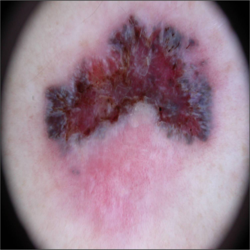

In [130]:
image_path = path_list[n_image]
img = PIL.Image.open(image_path)
img = img.resize((250,250));img

In [131]:
#Print predicted class and actual class
yc_pred = net4_data_augmentation.predict(lime_test)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in lime_test], axis=0)
y_test = np.argmax(yc_test, axis=1)
p = y_pred[n_image]
if p == 0:
    p = "Melanoma"
elif p == 1:
    p = "Nevus"
elif p == 2:
    p = "Seborrheic Keratosis"
a = y_test[n_image]
label = a
if a == 0:
    a = "Melanoma"
elif a == 1:
    a = "Nevus"
elif a == 2:
    a = "Seborrheic Keratosis"

print("Predicted class: ", p)
print("Actual class: ", a)

<IPython.core.display.Javascript object>

1/1 [==============================] - 2s 2s/step
Predicted class:  Melanoma
Actual class:  Melanoma


In [132]:
# Transform the image using the transform_img_fn function
# by providing the image path as a list
images = transform_img_fn([image_path])

<IPython.core.display.Javascript object>

In [133]:
# Create an instance of the LimeImageExplainer
explainer = lime_image.LimeImageExplainer()

# Explain the instance by generating an explanation
# The explanation is generated for the first image in the 'images' list
# The image is casted to 'double' type using the 'astype' method
# The prediction function 'net4_data_augmentation.predict' is used to predict the class labels
# The 'top_labels' parameter specifies the number of top labels to include in the explanation
explanation = explainer.explain_instance(images[0].astype('double'), net4_data_augmentation.predict, top_labels=5)


<IPython.core.display.Javascript object>

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  1%|          | 10/1000 [00:03<05:10,  3.19it/s]

1/1 [==============================] - 0s 286ms/step


  2%|▏         | 20/1000 [00:03<02:33,  6.40it/s]

1/1 [==============================] - 0s 304ms/step


  3%|▎         | 30/1000 [00:04<01:42,  9.46it/s]

1/1 [==============================] - 0s 305ms/step


  4%|▍         | 40/1000 [00:04<01:19, 12.01it/s]

1/1 [==============================] - 0s 351ms/step


  5%|▌         | 50/1000 [00:05<01:08, 13.92it/s]

1/1 [==============================] - 0s 377ms/step


  6%|▌         | 60/1000 [00:05<01:02, 14.96it/s]

1/1 [==============================] - 0s 355ms/step


  7%|▋         | 70/1000 [00:06<01:11, 13.09it/s]

1/1 [==============================] - 0s 332ms/step


  8%|▊         | 80/1000 [00:07<01:02, 14.69it/s]

1/1 [==============================] - 0s 322ms/step


  9%|▉         | 90/1000 [00:07<00:55, 16.28it/s]

1/1 [==============================] - 0s 324ms/step


 11%|█         | 108/1000 [00:08<00:41, 21.41it/s]

1/1 [==============================] - 0s 354ms/step


 11%|█         | 112/1000 [00:08<00:52, 16.77it/s]

1/1 [==============================] - 0s 296ms/step


 12%|█▏        | 120/1000 [00:09<00:52, 16.84it/s]

1/1 [==============================] - 0s 304ms/step


 13%|█▎        | 130/1000 [00:09<00:47, 18.45it/s]

1/1 [==============================] - 0s 292ms/step


 14%|█▍        | 140/1000 [00:10<00:43, 19.68it/s]

1/1 [==============================] - 0s 364ms/step


 15%|█▌        | 150/1000 [00:10<00:43, 19.53it/s]

1/1 [==============================] - 0s 306ms/step


 16%|█▌        | 160/1000 [00:11<00:41, 20.03it/s]

1/1 [==============================] - 0s 347ms/step


 17%|█▋        | 170/1000 [00:11<00:41, 19.82it/s]

1/1 [==============================] - 0s 331ms/step


 18%|█▊        | 180/1000 [00:12<00:40, 20.10it/s]

1/1 [==============================] - 0s 312ms/step


 19%|█▉        | 190/1000 [00:12<00:39, 20.63it/s]

1/1 [==============================] - 0s 311ms/step


 20%|██        | 200/1000 [00:12<00:38, 20.67it/s]

1/1 [==============================] - 0s 309ms/step


 21%|██        | 210/1000 [00:13<00:37, 21.20it/s]

1/1 [==============================] - 0s 301ms/step


 22%|██▏       | 220/1000 [00:14<00:39, 19.60it/s]

1/1 [==============================] - 0s 363ms/step


 23%|██▎       | 230/1000 [00:14<00:39, 19.60it/s]

1/1 [==============================] - 0s 363ms/step


 24%|██▍       | 240/1000 [00:15<00:39, 19.21it/s]

1/1 [==============================] - 0s 385ms/step


 25%|██▌       | 250/1000 [00:15<00:39, 18.91it/s]

1/1 [==============================] - 0s 370ms/step


 26%|██▌       | 260/1000 [00:16<00:39, 18.97it/s]

1/1 [==============================] - 0s 326ms/step


 27%|██▋       | 270/1000 [00:16<00:37, 19.60it/s]

1/1 [==============================] - 0s 308ms/step


 28%|██▊       | 280/1000 [00:17<00:36, 19.84it/s]

1/1 [==============================] - 0s 313ms/step


 29%|██▉       | 290/1000 [00:17<00:34, 20.43it/s]

1/1 [==============================] - 0s 339ms/step


 30%|███       | 300/1000 [00:18<00:35, 19.70it/s]

1/1 [==============================] - 0s 319ms/step


 31%|███       | 310/1000 [00:18<00:34, 20.26it/s]

1/1 [==============================] - 0s 318ms/step


 32%|███▏      | 320/1000 [00:19<00:33, 20.56it/s]

1/1 [==============================] - 0s 312ms/step


 33%|███▎      | 330/1000 [00:19<00:35, 19.13it/s]

1/1 [==============================] - 0s 328ms/step


 34%|███▍      | 340/1000 [00:20<00:33, 19.59it/s]

1/1 [==============================] - 0s 332ms/step


 35%|███▌      | 350/1000 [00:20<00:32, 19.96it/s]

1/1 [==============================] - 0s 311ms/step


 36%|███▌      | 360/1000 [00:21<00:31, 20.06it/s]

1/1 [==============================] - 0s 306ms/step


 37%|███▋      | 370/1000 [00:21<00:30, 20.53it/s]

1/1 [==============================] - 0s 307ms/step


 38%|███▊      | 380/1000 [00:22<00:29, 20.74it/s]

1/1 [==============================] - 0s 315ms/step


 39%|███▉      | 390/1000 [00:22<00:29, 20.97it/s]

1/1 [==============================] - 0s 336ms/step


 40%|████      | 400/1000 [00:22<00:28, 20.89it/s]

1/1 [==============================] - 0s 325ms/step


 41%|████      | 410/1000 [00:23<00:28, 21.04it/s]

1/1 [==============================] - 0s 331ms/step


 42%|████▏     | 420/1000 [00:23<00:27, 20.94it/s]

1/1 [==============================] - 0s 320ms/step


 43%|████▎     | 430/1000 [00:24<00:27, 21.02it/s]

1/1 [==============================] - 0s 325ms/step


 44%|████▍     | 440/1000 [00:25<00:29, 18.78it/s]

1/1 [==============================] - 0s 375ms/step


 45%|████▌     | 450/1000 [00:25<00:29, 18.81it/s]

1/1 [==============================] - 0s 318ms/step


 46%|████▌     | 460/1000 [00:26<00:27, 19.57it/s]

1/1 [==============================] - 0s 367ms/step


 47%|████▋     | 470/1000 [00:26<00:32, 16.45it/s]

1/1 [==============================] - 0s 304ms/step


 48%|████▊     | 480/1000 [00:27<00:29, 17.87it/s]

1/1 [==============================] - 0s 311ms/step


 49%|████▉     | 490/1000 [00:27<00:26, 18.98it/s]

1/1 [==============================] - 0s 343ms/step


 50%|█████     | 500/1000 [00:28<00:26, 18.52it/s]

1/1 [==============================] - 0s 344ms/step


 51%|█████     | 510/1000 [00:28<00:25, 19.03it/s]

1/1 [==============================] - 0s 330ms/step


 52%|█████▏    | 520/1000 [00:29<00:24, 19.36it/s]

1/1 [==============================] - 0s 323ms/step


 53%|█████▎    | 530/1000 [00:29<00:23, 19.86it/s]

1/1 [==============================] - 0s 321ms/step


 54%|█████▍    | 540/1000 [00:30<00:24, 18.73it/s]

1/1 [==============================] - 0s 333ms/step


 55%|█████▌    | 550/1000 [00:30<00:23, 19.28it/s]

1/1 [==============================] - 0s 340ms/step


 56%|█████▌    | 560/1000 [00:31<00:22, 19.59it/s]

1/1 [==============================] - 0s 322ms/step


 57%|█████▋    | 570/1000 [00:31<00:21, 20.05it/s]

1/1 [==============================] - 0s 333ms/step


 58%|█████▊    | 580/1000 [00:32<00:20, 20.36it/s]

1/1 [==============================] - 0s 349ms/step


 59%|█████▉    | 590/1000 [00:32<00:20, 20.41it/s]

1/1 [==============================] - 0s 330ms/step


 60%|██████    | 600/1000 [00:33<00:19, 20.51it/s]

1/1 [==============================] - 0s 332ms/step


 61%|██████    | 610/1000 [00:33<00:18, 20.65it/s]

1/1 [==============================] - 0s 315ms/step


 62%|██████▏   | 620/1000 [00:34<00:18, 21.11it/s]

1/1 [==============================] - 0s 343ms/step


 63%|██████▎   | 630/1000 [00:34<00:17, 20.85it/s]

1/1 [==============================] - 0s 335ms/step


 64%|██████▍   | 640/1000 [00:35<00:18, 19.26it/s]

1/1 [==============================] - 0s 316ms/step


 65%|██████▌   | 650/1000 [00:35<00:17, 19.78it/s]

1/1 [==============================] - 0s 322ms/step


 66%|██████▌   | 660/1000 [00:36<00:16, 20.09it/s]

1/1 [==============================] - 0s 333ms/step


 67%|██████▋   | 670/1000 [00:36<00:16, 20.40it/s]

1/1 [==============================] - 0s 421ms/step


 68%|██████▊   | 680/1000 [00:37<00:16, 19.36it/s]

1/1 [==============================] - 0s 326ms/step


 69%|██████▉   | 690/1000 [00:37<00:15, 19.70it/s]

1/1 [==============================] - 0s 349ms/step


 70%|███████   | 700/1000 [00:38<00:15, 19.35it/s]

1/1 [==============================] - 0s 320ms/step


 71%|███████   | 710/1000 [00:38<00:14, 19.79it/s]

1/1 [==============================] - 0s 329ms/step


 72%|███████▏  | 720/1000 [00:39<00:13, 20.10it/s]

1/1 [==============================] - 0s 472ms/step


 73%|███████▎  | 730/1000 [00:39<00:14, 18.76it/s]

1/1 [==============================] - 0s 330ms/step


 74%|███████▍  | 740/1000 [00:40<00:13, 19.30it/s]

1/1 [==============================] - 0s 345ms/step


 75%|███████▌  | 750/1000 [00:40<00:12, 19.58it/s]

1/1 [==============================] - 0s 322ms/step


 76%|███████▌  | 760/1000 [00:41<00:11, 20.02it/s]

1/1 [==============================] - 0s 348ms/step


 77%|███████▋  | 770/1000 [00:41<00:11, 20.22it/s]

1/1 [==============================] - 0s 314ms/step


 78%|███████▊  | 780/1000 [00:42<00:10, 20.67it/s]

1/1 [==============================] - 0s 337ms/step


 79%|███████▉  | 790/1000 [00:42<00:10, 20.75it/s]

1/1 [==============================] - 0s 324ms/step


 80%|████████  | 800/1000 [00:43<00:09, 21.02it/s]

1/1 [==============================] - 0s 338ms/step


 81%|████████  | 810/1000 [00:43<00:09, 20.92it/s]

1/1 [==============================] - 0s 331ms/step


 82%|████████▏ | 820/1000 [00:44<00:08, 20.79it/s]

1/1 [==============================] - 0s 406ms/step


 83%|████████▎ | 830/1000 [00:44<00:09, 18.67it/s]

1/1 [==============================] - 0s 324ms/step


 84%|████████▍ | 840/1000 [00:45<00:08, 18.77it/s]

1/1 [==============================] - 0s 317ms/step


 85%|████████▌ | 850/1000 [00:45<00:07, 19.44it/s]

1/1 [==============================] - 0s 332ms/step


 86%|████████▌ | 860/1000 [00:46<00:07, 19.92it/s]

1/1 [==============================] - 0s 341ms/step


 87%|████████▋ | 870/1000 [00:46<00:06, 20.05it/s]

1/1 [==============================] - 0s 334ms/step


 88%|████████▊ | 880/1000 [00:47<00:05, 20.30it/s]

1/1 [==============================] - 0s 416ms/step


 89%|████████▉ | 890/1000 [00:47<00:05, 19.44it/s]

1/1 [==============================] - 0s 339ms/step


 90%|█████████ | 900/1000 [00:48<00:05, 19.74it/s]

1/1 [==============================] - 0s 330ms/step


 92%|█████████▏| 915/1000 [00:49<00:03, 22.12it/s]

1/1 [==============================] - 0s 320ms/step


 92%|█████████▏| 920/1000 [00:49<00:04, 18.02it/s]

1/1 [==============================] - 0s 331ms/step


 93%|█████████▎| 930/1000 [00:49<00:03, 19.14it/s]

1/1 [==============================] - 0s 326ms/step


 94%|█████████▍| 940/1000 [00:50<00:03, 19.86it/s]

1/1 [==============================] - 0s 393ms/step


 95%|█████████▌| 950/1000 [00:50<00:02, 19.53it/s]

1/1 [==============================] - 0s 335ms/step


 96%|█████████▌| 960/1000 [00:51<00:02, 19.96it/s]

1/1 [==============================] - 0s 340ms/step


 97%|█████████▋| 970/1000 [00:51<00:01, 20.20it/s]

1/1 [==============================] - 0s 329ms/step


 98%|█████████▊| 980/1000 [00:52<00:00, 20.46it/s]

1/1 [==============================] - 0s 333ms/step


 99%|█████████▉| 990/1000 [00:52<00:00, 20.65it/s]

1/1 [==============================] - 0s 321ms/step


100%|██████████| 1000/1000 [00:53<00:00, 18.74it/s]


<IPython.core.display.Javascript object>

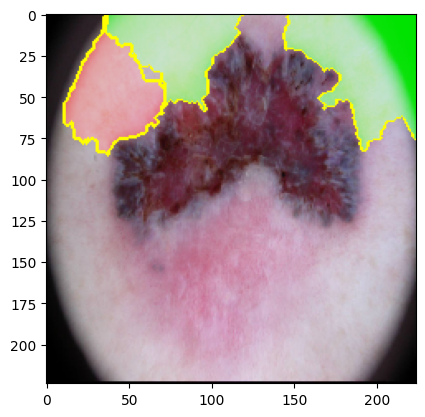

In [136]:
# Obtain the image mask and the corresponding image
# The mask represents the important regions in the image for the given label
# The 'explanation.top_labels[label]' retrieves the label for which the mask is generated
# The 'positive_only' parameter specifies whether to include only positive features in the mask
# The 'num_features' parameter determines the number of top features to include in the mask
# The 'hide_rest' parameter determines whether to hide the non-selected features in the mask
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[label], positive_only=False, num_features=5, hide_rest=False
)

# Visualize the image and the mask using the 'imshow' function from matplotlib
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))